In [2]:
# 패키지 설치

import warnings 
warnings.filterwarnings(action='ignore')
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sb
import sys
from pandas import DataFrame,read_excel, melt, pivot_table, concat, merge
from matplotlib import pyplot as plt
from math import sqrt
from scipy.stats import t, ttest_1samp, normaltest, bartlett, levene, ttest_ind, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator


In [4]:
plt.rcParams['font.family']='AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size']=12
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.unicode_minus']=False

In [5]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/수업자료/cookie_cats.xlsx')
origin

,userid,version,sum_gamerounds
0,116,A,3
1,337,A,38
2,377,B,165
3,483,B,1
4,488,B,179
...,...,...,...
90184,9999441,B,97
90185,9999479,B,30
90186,9999710,A,28
90187,9999768,B,51


In [10]:
# 데이터 재구조화

df = origin.pivot_table(index='userid',
                 columns='version',
                 values='sum_gamerounds'
                 )
df

version,A,B
userid,,
116,3.0,NaN
337,38.0,NaN
377,NaN,165.0
483,NaN,1.0
488,NaN,179.0
...,...,...
9999441,NaN,97.0
9999479,NaN,30.0
9999710,28.0,NaN


In [51]:
# A열의 결측치 제거, 플레이시간 0시간 제외

df_A = df[['A']]
#df_A.info()
df_A1 = df_A.dropna()
df_A2 = df_A1.query('A != 0').reset_index(drop=True)
df_A2

# B열의 결측치 제거, 플레이시간 0시간 제외

df_B = df[['B']]
#df_B.info()
df_B1 = df_B.dropna().sort_values('B').reset_index(drop=True)
df_B2 = df_B1.query('B != 0').reset_index(drop=True)
df_B3 = df_B2.query('B > 128.5').reset_index(drop=True)
df_B_drop = df_B2.drop(df_B2.index[42763:])
df_B_drop




version,B
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
42758,415.0
42759,416.0
42760,416.0
42761,416.0


In [52]:
# A,B컬럼 행 개수 42763개로 맞춤 => 병합

df_AB = merge(df_A2,df_B_drop,left_index=True,right_index=True,how='outer')
df_AB

version,A,B
0,3.0,1.0
1,38.0,1.0
2,39.0,1.0
3,305.0,1.0
4,73.0,1.0
...,...,...
42758,14.0,415.0
42759,7.0,416.0
42760,21.0,416.0
42761,10.0,416.0


In [60]:
# B열의 개수가 많으므로 A열의 개수에 맞도록 앞 뒤 제거(이상치에 포함되는지 확인)

Q1 = df_AB['B'].quantile(0.25)
Q3 = df_AB['B'].quantile(0.75)
iqr = Q3 - Q1

outline_max = Q3 + iqr * 1.5
outline_min = Q1 - iqr * 1.5

df_AB.loc[df_AB['B'] > outline_max, 'B'] = np.nan
df_AB.loc[df_AB['B'] <= outline_min, 'B'] = np.nan

B = df_AB 


Q1_A = df_AB['A'].quantile(0.25)
Q3_A = df_AB['A'].quantile(0.75)
iqr_A = Q3_A - Q1_A

outline_max_A = Q3_A + iqr_A * 1.5
outline_min_A = Q1_A - iqr_A * 1.5

df_AB.loc[df_AB['A'] > outline_max_A, 'A'] = np.nan
df_AB.loc[df_AB['A'] <= outline_min_A, 'A'] = np.nan
df_AB


#결측치 정제 

imr = SimpleImputer(missing_values=np.nan,strategy='mean')
imr
df_imr = imr.fit_transform(df_AB.values)
df_imr
re_df_AB = DataFrame(df_imr,index=df_AB.index,columns=df_AB.columns)
re_df_AB

version,A,B
0,3.000000,1.000000
1,38.000000,1.000000
2,39.000000,1.000000
3,16.720796,1.000000
4,16.720796,1.000000
...,...,...
42758,14.000000,14.613716
42759,7.000000,14.613716
42760,21.000000,14.613716
42761,10.000000,14.613716


In [63]:
# log데이터로 변환

log_df_AB = np.log(re_df_AB)
log_df_AB

version,A,B
0,1.098612,0.000000
1,3.637586,0.000000
2,3.663562,0.000000
3,2.816653,0.000000
4,2.816653,0.000000
...,...,...
42758,2.639057,2.681961
42759,1.945910,2.681961
42760,3.044522,2.681961
42761,2.302585,2.681961


In [67]:
# log데이터 이상치 정제

Q1_log_B = log_df_AB['B'].quantile(0.25)
Q3_log_B = log_df_AB['B'].quantile(0.75)
iqr_log_B = Q3_log_B - Q1_log_B

outline_max_log_B = Q3_log_B + iqr_log_B * 1.5
outline_min_log_B = Q1_log_B - iqr_log_B * 1.5

log_df_AB.loc[log_df_AB['B'] > outline_max_log_B, 'B'] = np.nan
log_df_AB.loc[log_df_AB['B'] <= outline_min_log_B, 'B'] = np.nan


Q1_log_A = log_df_AB['A'].quantile(0.25)
Q3_log_A = log_df_AB['A'].quantile(0.75)
iqr_log_A = Q3_log_A - Q1_log_A

outline_max_log_A = Q3_log_A + iqr_log_A * 1.5
outline_min_log_A = Q1_log_A - iqr_log_A * 1.5

log_df_AB.loc[log_df_AB['A'] > outline_max_log_A, 'A'] = np.nan
log_df_AB.loc[log_df_AB['A'] <= outline_min_log_A, 'A'] = np.nan
log_df_AB


#결측치 정제 

imr = SimpleImputer(missing_values=np.nan,strategy='mean')
imr
df_imr_log = imr.fit_transform(log_df_AB.values)
df_imr_log
log_re_df_AB = DataFrame(df_imr_log,index=log_df_AB.index,columns=log_df_AB.columns)
log_re_df_AB

version,A,B
0,1.098612,2.462454
1,3.637586,2.462454
2,3.663562,2.462454
3,2.816653,2.462454
4,2.816653,2.462454
...,...,...
42758,2.639057,2.681961
42759,1.945910,2.681961
42760,3.044522,2.681961
42761,2.302585,2.681961


In [167]:
# A,B 모두 1.0 미만인 값 제거
log_re_df_AB1 = log_re_df_AB.query('A >= 1.75 and B >= 1.75')
log_re_df_AB1

#A,B 모두 3.7 초과인 값 제거
log_re_df_AB2 = log_re_df_AB1.query('A <= 3.9 and B <= 3.9')
log_re_df_AB2



version,A,B
1,3.637586,2.462454
2,3.663562,2.462454
3,2.816653,2.462454
4,2.816653,2.462454
5,2.639057,2.462454
...,...,...
42758,2.639057,2.681961
42759,1.945910,2.681961
42760,3.044522,2.681961
42761,2.302585,2.681961


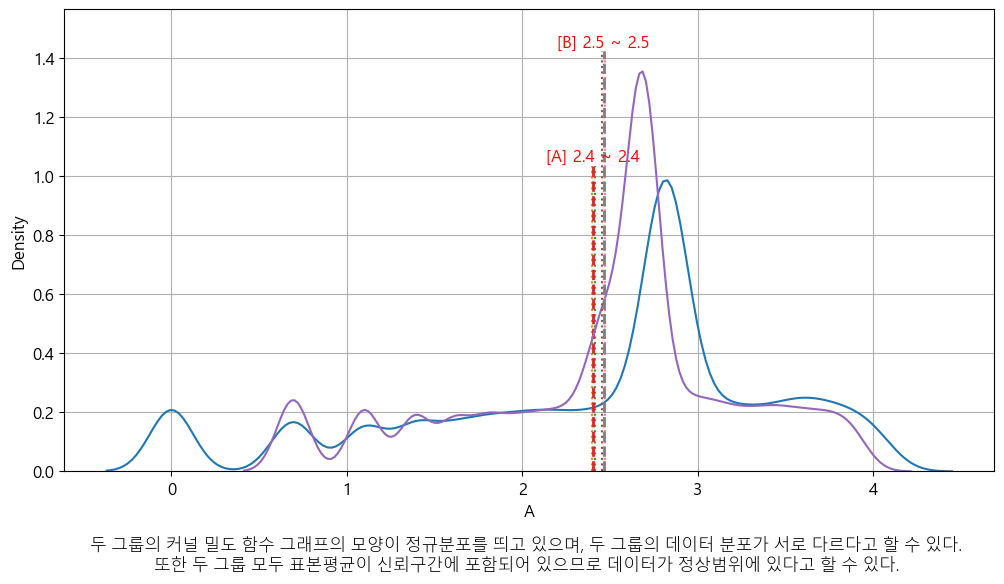

In [170]:
# 신뢰구간


plt.figure()

for c in re_df_AB.columns:
    #print(c)

    data = re_df_AB[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [171]:
# 정규성 검정

for c in log_re_df_AB.columns:
    s, p = normaltest(log_re_df_AB[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[A] statistic: 3337.586, p-value: 0.000, 정규성 충족 여부: False
[B] statistic: 1911.163, p-value: 0.000, 정규성 충족 여부: False


In [173]:
# 등분산성 검정

normal_dist = False      # 정규성 만족 여부
data = log_re_df_AB.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p >= 0.05))

Levene 검정: statistic: 1918.638, p-value: 0.000, 등분산성 충족 여부: False


In [ ]:
# 정규성, 등분산성 모두 만족하지 않으므로 비모수적 방법인 mannwhitneyu 검정을 함
# 귀무가설: 업데이트 전후 유저의 플레이시간의 차이가 없다.
# 대립가설: 업데이트 전후 유저의 플레이시간의 차이가 있다.

In [174]:
s, p = mannwhitneyu(log_re_df_AB['A'], log_re_df_AB['B'], alternative='two-sided')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 978840209.000, p-value: 0.000, 대립가설 채택'

> 대응표본 검정결과에서 p값이 `0.000`으로 유의수준 `0.05`보다 작으므로 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 업데이트 전후 유저의 플레이시간에 차이가 있다고 볼 수 있다.

In [ ]:
# 업데이트 전 유저 플레이시간이 길다고 대립가설 설정
# 귀무가설: 업데이트 전 유저의 플레이시간이 후보다 길지 않다.
# 대립가설: 업데이트 전 유저의 플레이시간이 후보다 길다.

In [175]:
s, p = mannwhitneyu(log_re_df_AB['A'], log_re_df_AB['B'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 978840209.000, p-value: 0.000, 대립가설 채택'

> 대응표본 검정결과에서 p값이 `0.000`으로 유의수준 `0.05`보다 작으므로 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 업데이트 전 유저의 플레이시간이 업데이트 후보다 길다고 볼 수 있다.

In [ ]:
# 업데이트 전 유저 플레이시간이 짧다고 대립가설 설정
# 귀무가설: 업데이트 전 유저의 플레이시간이 후보다 짧지 않다.
# 대립가설: 업데이트 전 유저의 플레이시간이 후보다 짧다.

In [176]:
s, p = mannwhitneyu(log_re_df_AB['A'], log_re_df_AB['B'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 978840209.000, p-value: 1.000, 귀무가설 채택'

> 대응표본 검정결과에서 p값이 `1.000`으로 유의수준 `0.05`보다 크므로 대립가설을 기각하고 귀무가설을 채택한다.
>
> 즉, 업데이트 전 유저의 플레이시간이 업데이트 후보다 짧지 않다고 볼 수 있다.

In [177]:
# 시각화

df_AB_box = melt(log_re_df_AB, var_name='group', value_name='value')
df_AB_box

,group,value
0,A,1.098612
1,A,3.637586
2,A,3.663562
3,A,2.816653
4,A,2.816653
...,...,...
85521,B,2.681961
85522,B,2.681961
85523,B,2.681961
85524,B,2.681961


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B: Mann-Whitney-Wilcoxon test two-sided, P_val:1.101e-71 U_stat=9.788e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B: Mann-Whitney-Wilcoxon test smaller, P_val:1.000e+00 U_stat=9.788e+08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

A vs. B: Mann-Whitney-Wilcoxon test greater, P_val:5.506e-72 U_stat=9.788e+08


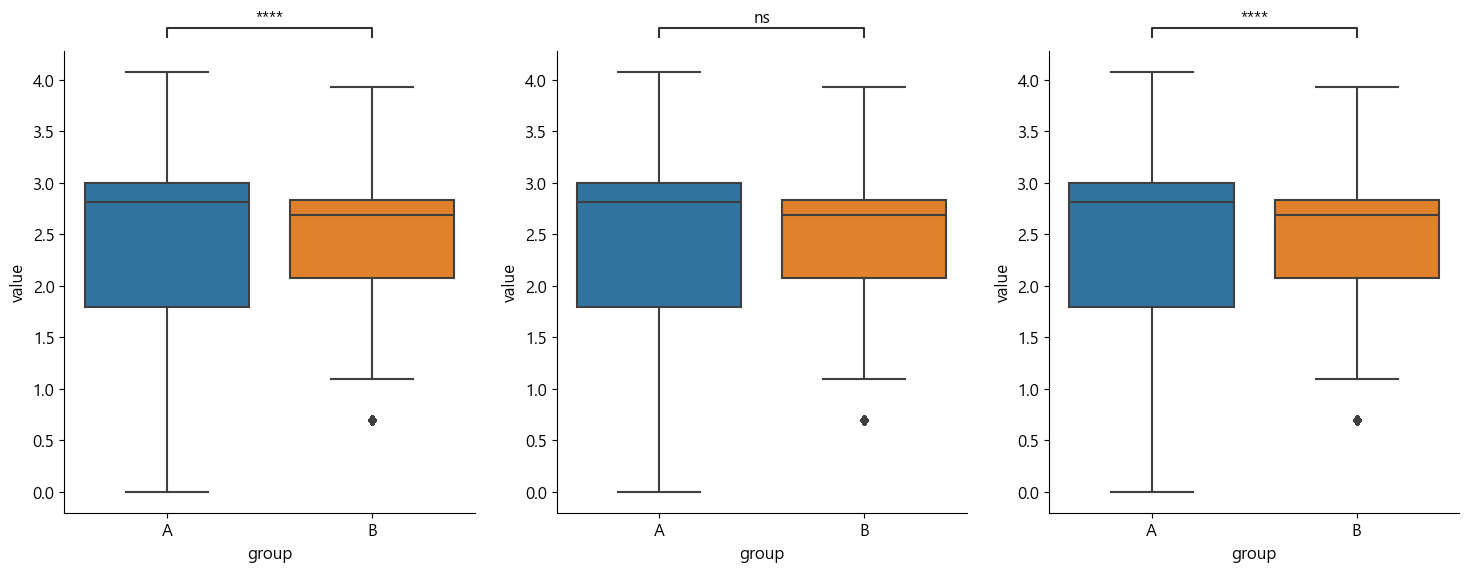

In [182]:
test = ['Mann-Whitney', 'Mann-Whitney-ls', 'Mann-Whitney-gt']

config = {
    "data": df_AB_box,
    "x": "group",
    "y": "value",
    "pairs": [("A", "B")],
    "test": None,
    "text_format": "star",
    "loc": "outside"
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, v in enumerate(ax):
    
    config['test'] = test[i]

    k = sb.boxplot(ax=v, data=config['data'], x=config['x'], y=config['y'])
    v.get_xaxis().axis_name

    annotator = Annotator(k, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
    annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
    annotator.apply_and_annotate()

    sb.despine(ax=v)

plt.show()
plt.close()